In [82]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

In [161]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [118]:
pokemon = pd.read_csv("pokemon.csv") # Dataset pokemon stats
combats = pd.read_csv("combats.csv") # Dataset pokemon battles and who won

pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

<AxesSubplot:>

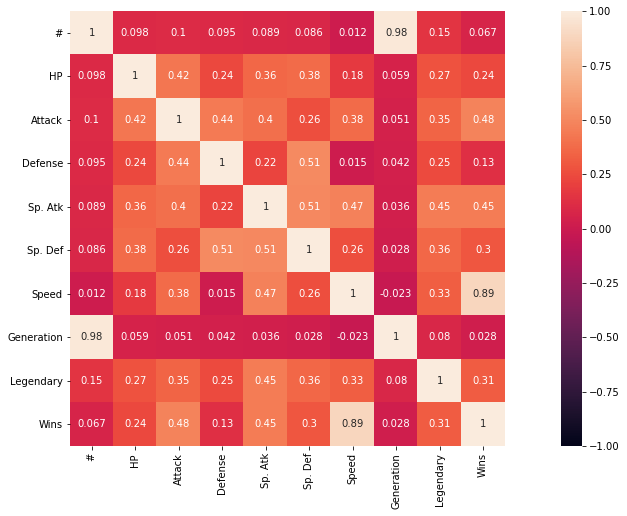

In [85]:
unique_ids=pokemon['#']
wins_by_id = []
for _id in unique_ids:
    wins_by_id.append([_id ,(combats["Winner"] == _id).sum() ])
    
wins_by_id = np.asarray(wins_by_id)

pokemon["Wins"] = wins_by_id[:,1]
pokemon["Type 2"] = pokemon["Type 2"].fillna("NA")
pokemon["Legendary"] = pokemon["Legendary"].astype(int)

plt.figure(figsize=(20,8))
sns.heatmap(pokemon.corr(),square=True, vmin=-1, vmax=1, annot=True)



### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

<AxesSubplot:xlabel='Attack', ylabel='Wins'>

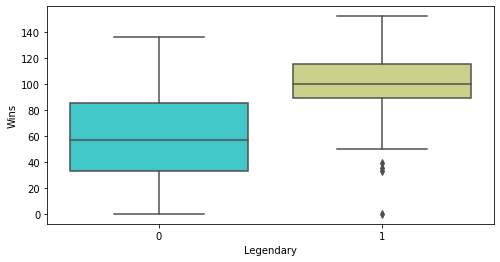

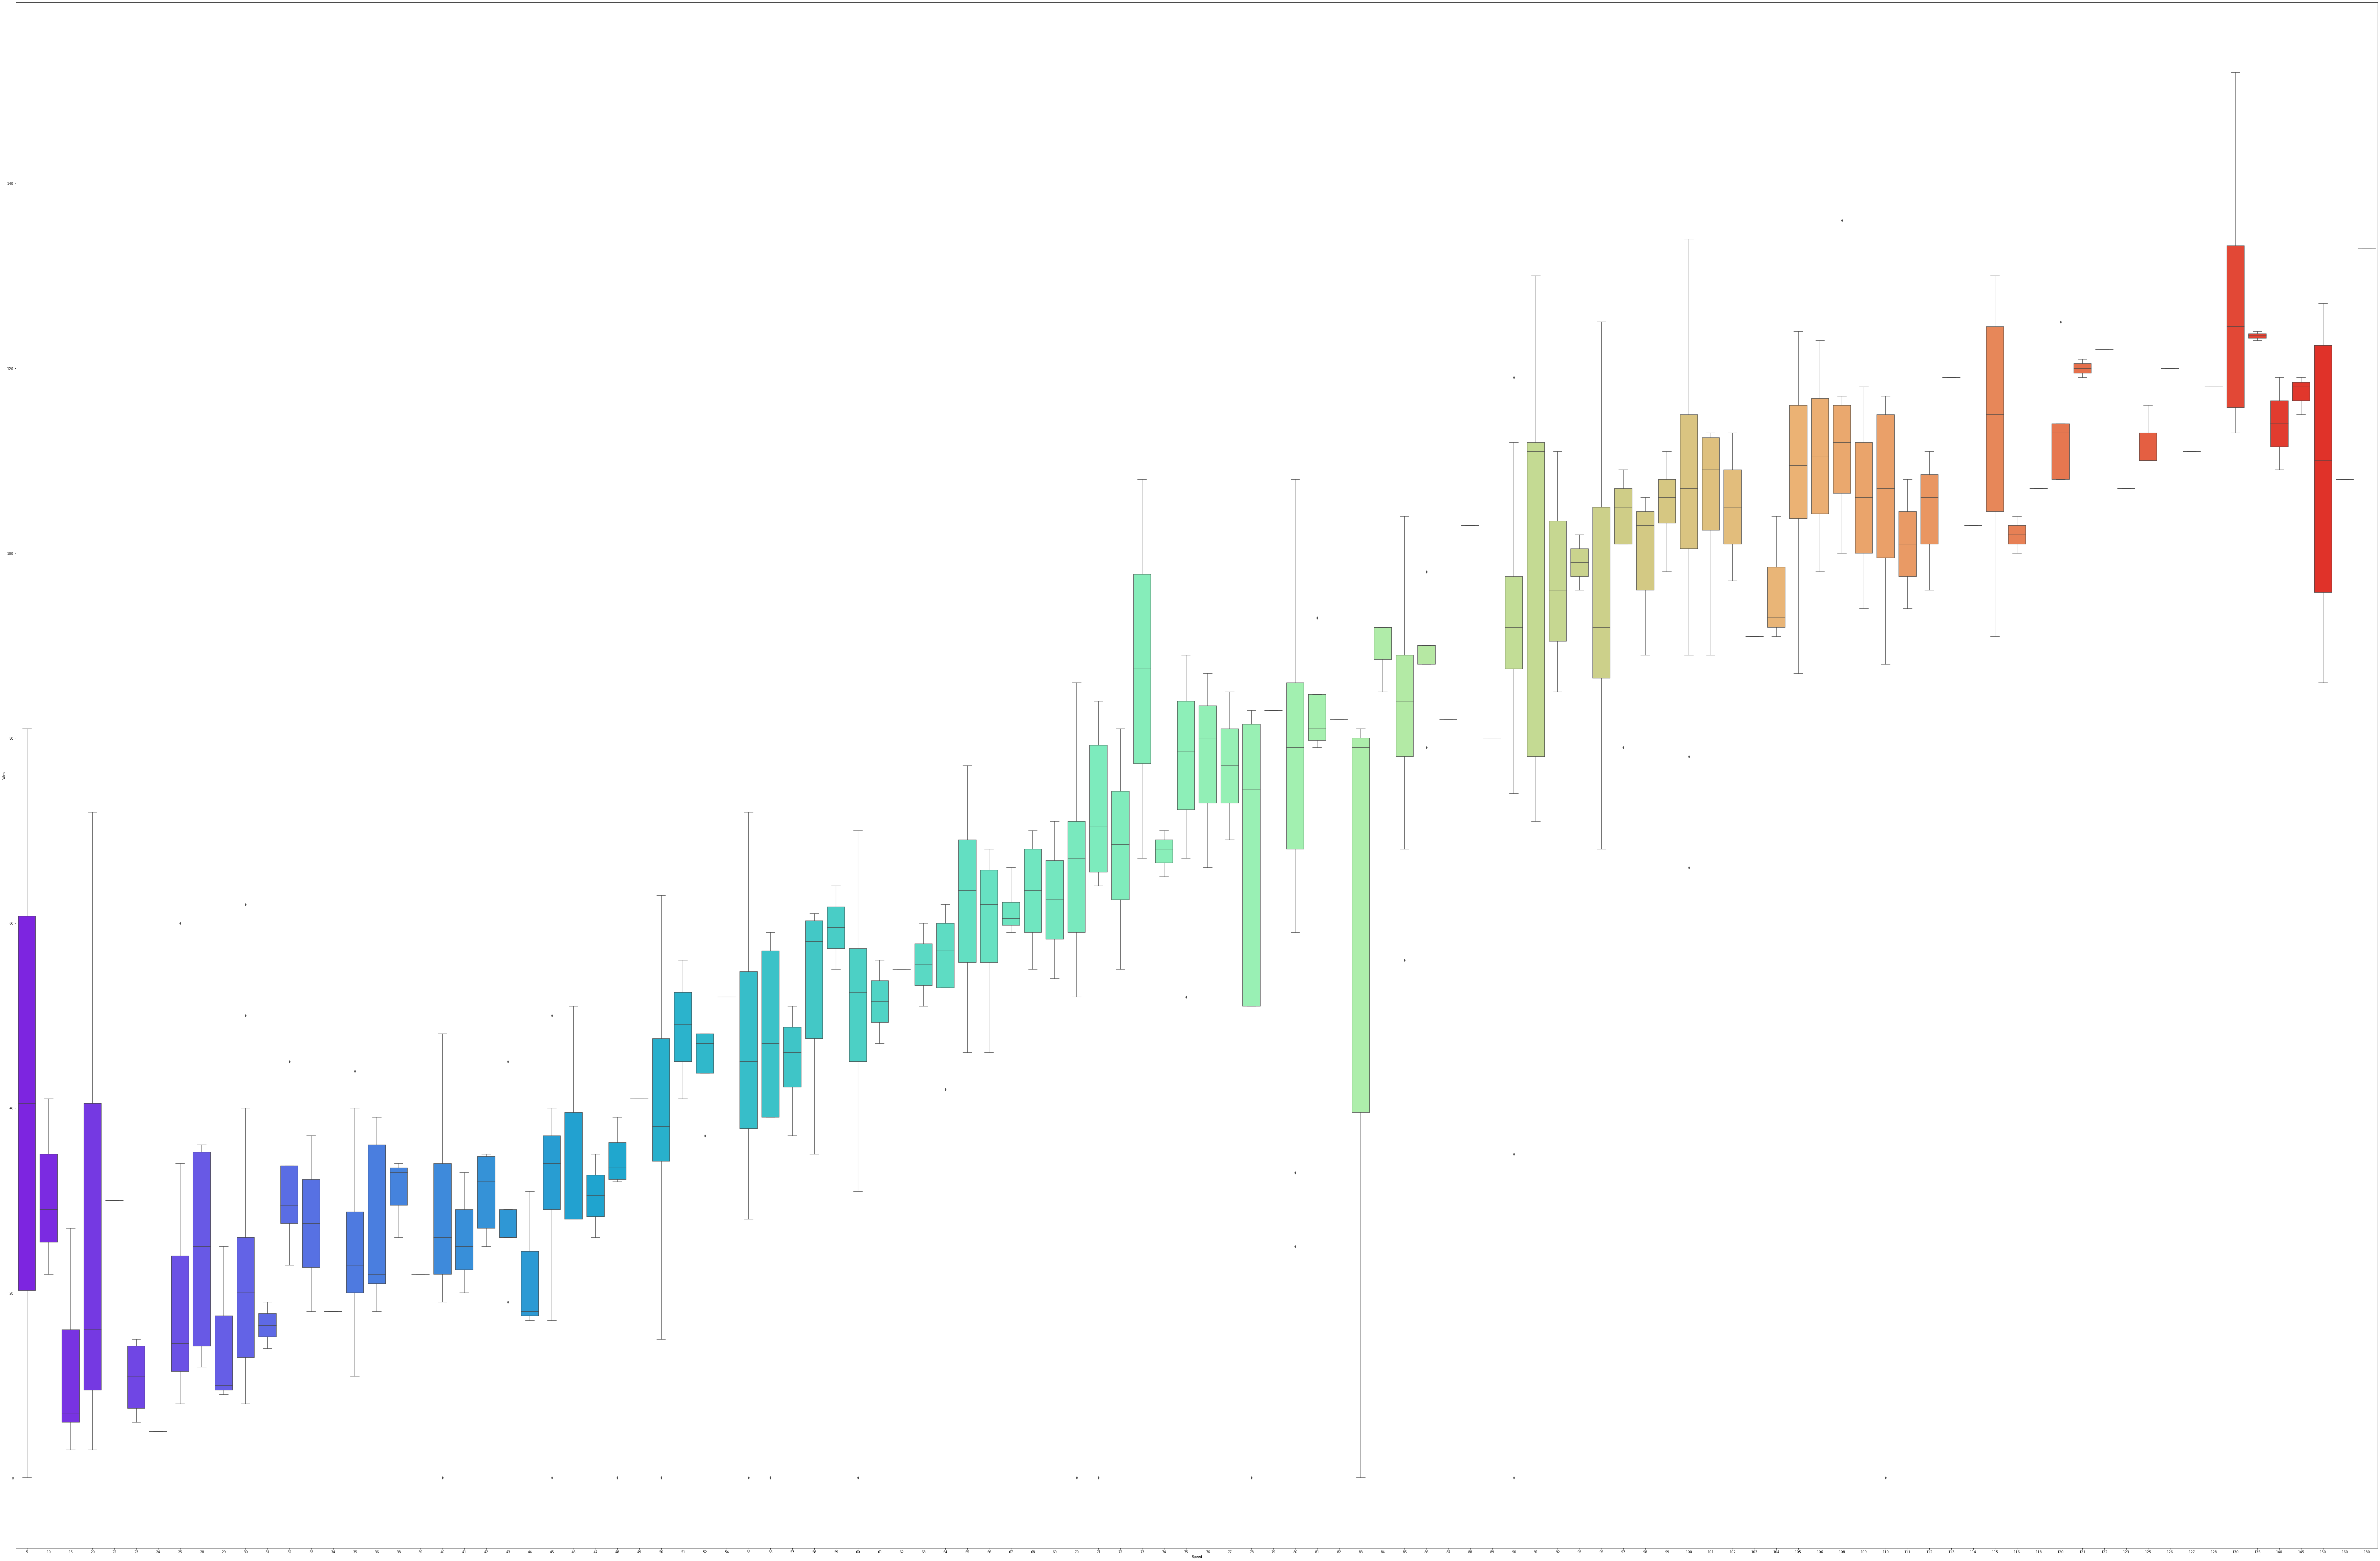

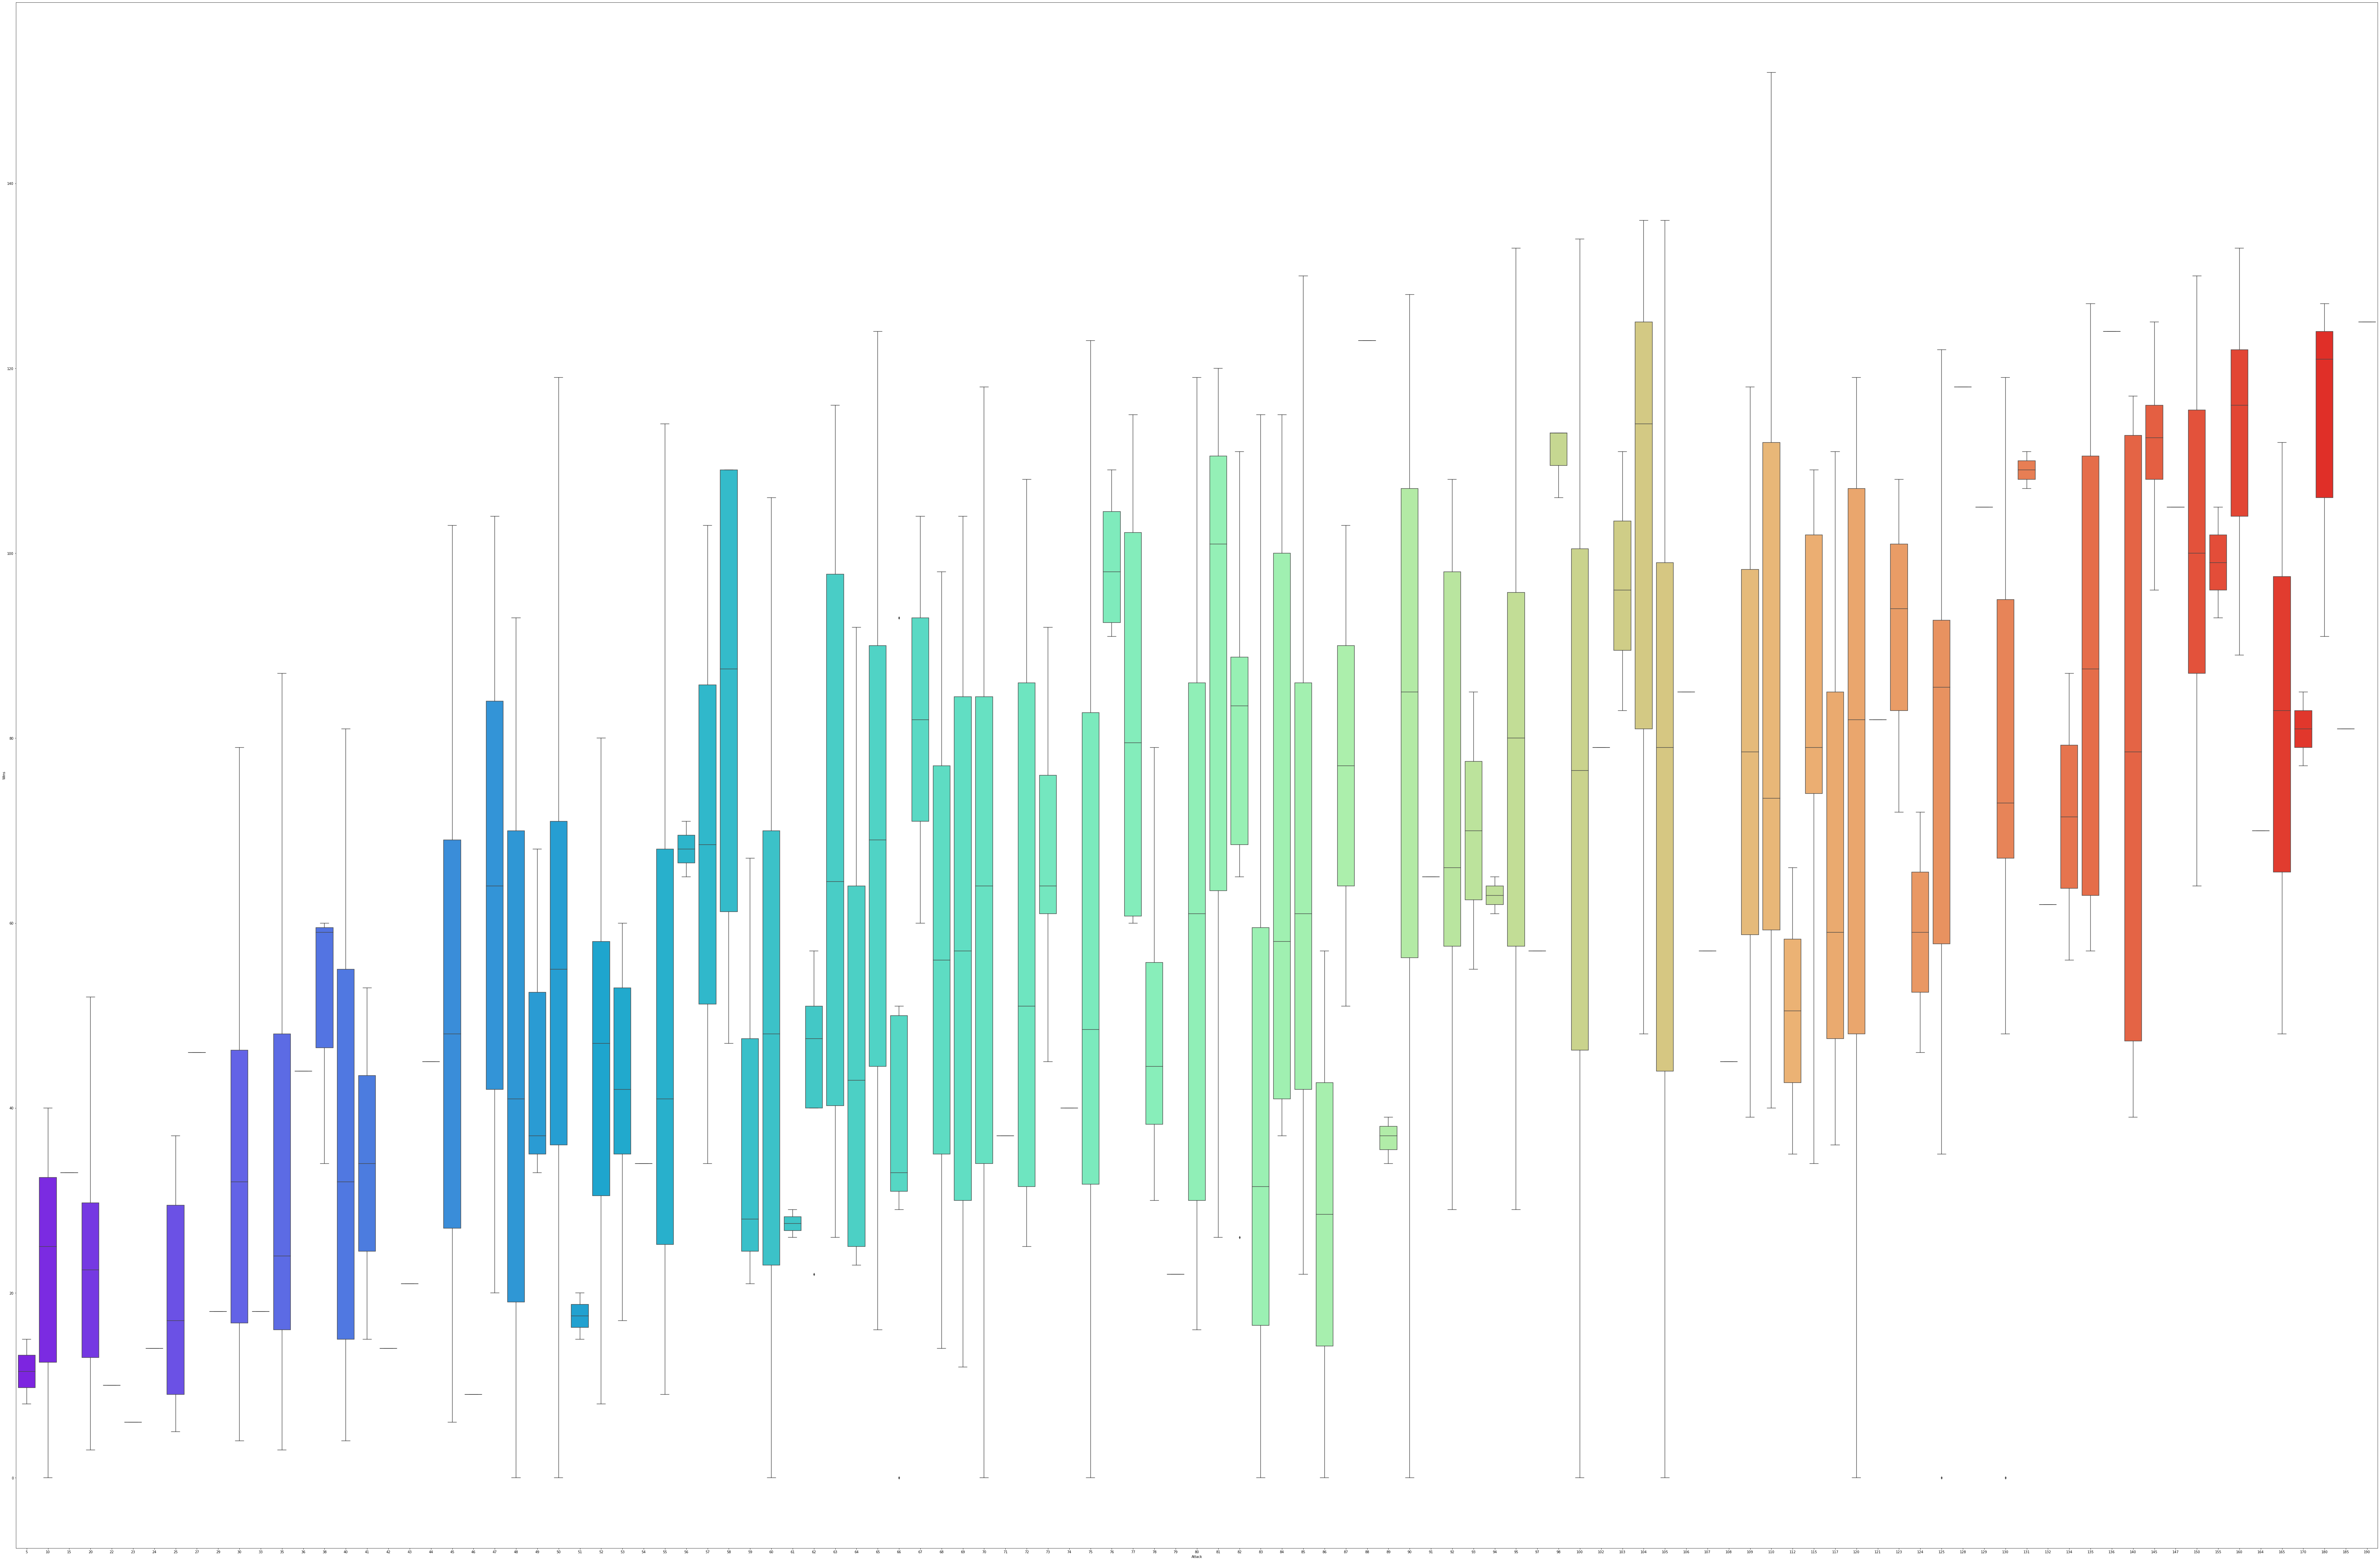

In [86]:
#boxplot of Attack vs. Legendary
plt.figure(figsize=(8, 4))
sns.boxplot(x='Legendary',y='Wins',data=pokemon, palette='rainbow')


#stripplot of Speed vs. Wins
plt.figure(figsize=(125, 84))
sns.boxplot(x='Speed',y='Wins',data=pokemon, palette='rainbow')
#stripplot of Attack vs. Wins
plt.figure(figsize=(125, 84))
sns.boxplot(x='Attack',y='Wins',data=pokemon, palette='rainbow')

<AxesSubplot:xlabel='Type 1'>

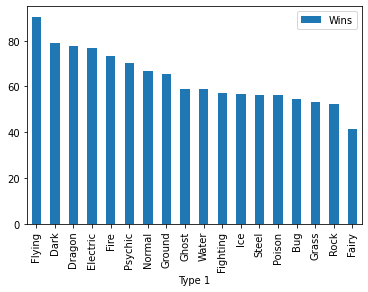

In [87]:
type_1 = pokemon[['Type 1','Wins']].groupby(['Type 1'], as_index=False).mean().set_index('Type 1')
type_1.sort_values(by='Wins',ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='Type 2'>

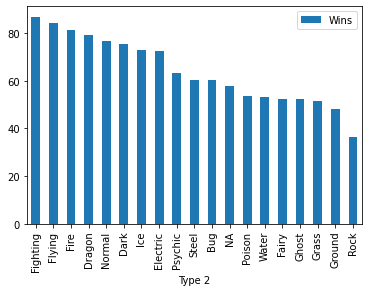

In [88]:
type_1 = pokemon[['Type 2','Wins']].groupby(['Type 2'], as_index=False).mean().set_index('Type 2')
type_1.sort_values(by='Wins',ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='Attack'>

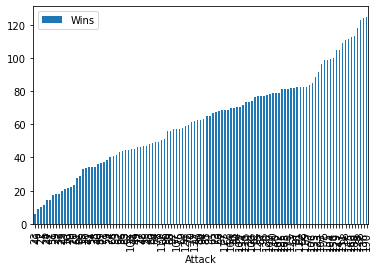

In [89]:
type_1 = pokemon[['Attack','Wins']].groupby(['Attack'], as_index=False).mean().set_index('Attack')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar')
#Number of wins is directly proportional too attack damage

<AxesSubplot:xlabel='Speed'>

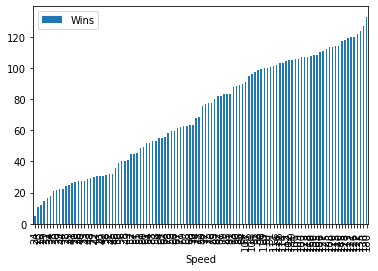

In [90]:
type_1 = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).mean().set_index('Speed')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar')
#Number of wins is directly proportional too Speed

In [94]:
map_Type_1 = {"NA" : 0}
i = 1
for t1 in pokemon["Type 1"].unique():
    if t1 == "NA":
        continue
    map_Type_1[t1] = i
    i += 1

map_Type_2 = {"NA" : 0}
i = 1
for t2 in pokemon["Type 2"].unique():
    if t2 == "NA":
        continue
    map_Type_2[t2] = i
    i += 2

pokemon["Type 1"] = pokemon["Type 1"].map(map_Type_1)
pokemon["Type 2"] = pokemon["Type 2"].map(map_Type_2)

pokemon.head()


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins
0,1,Bulbasaur,1,1,45,49,49,65,65,45,1,0,37
1,2,Ivysaur,1,1,60,62,63,80,80,60,1,0,46
2,3,Venusaur,1,1,80,82,83,100,100,80,1,0,89
3,4,Mega Venusaur,1,1,80,100,123,122,120,80,1,0,70
4,5,Charmander,2,3,39,52,43,60,50,65,1,0,55


In [108]:
data = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner
    
    x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
    y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
    diff = (x[4:9]-y[4:9]) # difference between "base stats hp...."
    
    z = np.concatenate((x,y))[-3:]
    z = np.append(diff,z,0)
    
    if winner == first_pokemon:
        z = np.append(z, [0])
    else:
        z = np.append(z, [1])
        
    data.append(z)
    
data = np.asarray(data)
X = data[:, :-1].astype(int)
y = data[:, -1].astype(int)

print(data)
print(pokemon.columns)

[[10 -15 10 ... 0 48 1]
 [-18 18 39 ... 1 105 1]
 [10 -45 10 ... 0 21 1]
 ...
 [40 25 10 ... 0 79 1]
 [-20 -40 0 ... 0 24 0]
 [28 124 80 ... 0 21 0]]
Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Wins'],
      dtype='object')


In [150]:
data_pd_frame = pd.DataFrame(data, columns=["HP Diff", "Attack Diff", "Defens Diff", "Sp. Atk diff", "Sp. Def dif", "Speed diff", "Generation", "Legendary", "Win" ])
data_pd_frame = data_pd_frame.drop(columns="Generation")
for column in data_pd_frame.columns:
    data_pd_frame[column] = data_pd_frame[column].astype(int)

In [151]:
data_pd_frame.dtypes

HP Diff         int64
Attack Diff     int64
Defens Diff     int64
Sp. Atk diff    int64
Sp. Def dif     int64
Speed diff      int64
Legendary       int64
Win             int64
dtype: object

In [167]:

number_of_rows = data_pd_frame.shape[0]


X = data_pd_frame.drop(columns="Win").values
y = data_pd_frame.Win.values
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = LogisticRegression()
clf.fit(X_train[:30500], y_train[:30500])
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')




[1 1 1 ... 1 0 0]
90.35 percent


In [157]:
pd.DataFrame(zip(data_pd_frame.columns, np.transpose(clf.coef_[0])), columns=['features', 'coef']) 

,features,coef
0,HP Diff,-0.005842
1,Attack Diff,-0.001285
2,Defens Diff,0.000051
3,Sp. Atk diff,-0.063272
4,Sp. Def dif,-0.053945
5,Speed diff,0.002399
6,Legendary,0.006011


In [170]:
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train[:30500],y_train[:30500])
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))


pred = model.predict(X_train[30500:])
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_train[30500:]))
print(classification_report(y_train[30500:], pred))

Accuracy : 0.9468
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5941
           1       0.96      0.94      0.95      6559

    accuracy                           0.95     12500
   macro avg       0.95      0.95      0.95     12500
weighted avg       0.95      0.95      0.95     12500

Accuracy : 0.9422857142857143
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3296
           1       0.96      0.93      0.94      3704

    accuracy                           0.94      7000
   macro avg       0.94      0.94      0.94      7000
weighted avg       0.94      0.94      0.94      7000

